# Лабораторная работа 2

In [70]:
import seaborn as sns
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import hilbert
import unittest
from parameterized import parameterized, parameterized_class
from tabulate import tabulate
import numpy.testing

def run_test(TestCase):
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_runner.run(unittest.makeSuite(TestCase))

In [71]:
def cond_s(A):
    return np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A))

def cond_v(A):
    N = A.shape[0]
    det = abs(np.linalg.det(A))
    return np.prod([math.sqrt(sum([A[n, m] ** 2 for m in range(N)])) for n in range(N)]) / det

def cond_a(A):
    N = A.shape[0]
    C = np.linalg.inv(A)
    return max([np.linalg.norm(A[n,:]) * np.linalg.norm(C[:,n]) for n in range(N)])

# Решение уравнения методом LU-разложения

## LU-разложение

In [72]:
def decompose(A):
    N = A.shape[0]
    U = np.zeros((N, N))
    L = np.eye(N)

    for i in range(N):
        for j in range(N):
            m = min(i, j)
            s = sum([L[i, k] * U[k, j] for k in range(m)])
            if i <= j:
                U[i, j] = A[i, j] - s
            else:
                L[i, j] = (A[i, j] - s) / U[j, j]

    return L, U


In [73]:
def test_name(testcase_func, param_num, param):
    return "%s_%s" %(
        testcase_func.__name__,
        parameterized.to_safe_name("_".join(str(x) + 'x' + str(x) for x in param.args)),
    )

class DecomposeTestCase(unittest.TestCase):
    @parameterized.expand([(i,) for i in range(3, 11)], name_func=test_name)
    def test_decompose(self, size):
        H = hilbert(size)
        L, U = decompose(H)
        np.testing.assert_allclose(L , np.tril(L)) # check if L is lower triangular
        np.testing.assert_allclose(U, np.triu(U)) # check if U is upper triangular
        np.testing.assert_allclose(L @ U, H) # check if L * U == H

run_test(DecomposeTestCase)

test_decompose_10x10 (__main__.DecomposeTestCase) ... ok
test_decompose_3x3 (__main__.DecomposeTestCase) ... ok
test_decompose_4x4 (__main__.DecomposeTestCase) ... ok
test_decompose_5x5 (__main__.DecomposeTestCase) ... ok
test_decompose_6x6 (__main__.DecomposeTestCase) ... ok
test_decompose_7x7 (__main__.DecomposeTestCase) ... ok
test_decompose_8x8 (__main__.DecomposeTestCase) ... ok
test_decompose_9x9 (__main__.DecomposeTestCase) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.018s

OK


## Решение уравнения

In [74]:
def print_conds(matrix, matrix_name):
    a = cond_a(matrix)
    v = cond_v(matrix)
    s = cond_s(matrix)

    print(f'''
    Числа обусловленности матрицы {matrix_name}:
        Угловой критерий: {a}
        Объемный критерий: {v}
        Спектральный критерий: {s}
    ''')

    return a, v, s

def solve_substitution(L, b, forward=True):
    N = L.shape[0]
    x = np.zeros((N, 1))
    r = range(N)
    if not forward:
        r = reversed(r)
    for m in r:
        sum_r = range(m)
        if not forward:
            sum_r = range(N - 1, m, -1)
        x[m] = (b[m] - sum([L[m, i] * x[i] for i in sum_r])) / L[m, m]
    return x

def solve_lu(A, b, print_cond=False, matrix_name='A'):
    L, U = decompose(A)
    if print_cond:
        print_conds(A, matrix_name)
        print_conds(L, 'L')
        print_conds(U, 'U')
    y = solve_substitution(L, b) # Ly = b y = Ux
    x = solve_substitution(U, y, False)
    return x

In [75]:
class SolveLUTestCase(unittest.TestCase):
    @parameterized.expand([(i,) for i in range(3, 8)], name_func=test_name)
    def test_solve_lu(self, size):
        H = hilbert(size)
        x = np.ones((size, 1))
        b = H @ x
        x_actual = solve_lu(H, b)
        np.testing.assert_allclose(x, x_actual)

    @parameterized.expand([(i,) for i in range(10, 16)], name_func=test_name)
    def test_bad_matrices(self, size):
        H = hilbert(size)
        x = np.ones((size, 1))
        b = H @ x
        x_actual = solve_lu(H, b)
        self.assertRaises(AssertionError, np.testing.assert_allclose, x, x_actual)

run_test(SolveLUTestCase)

test_bad_matrices_10x10 (__main__.SolveLUTestCase) ... ok
test_bad_matrices_11x11 (__main__.SolveLUTestCase) ... ok
test_bad_matrices_12x12 (__main__.SolveLUTestCase) ... ok
test_bad_matrices_13x13 (__main__.SolveLUTestCase) ... ok
test_bad_matrices_14x14 (__main__.SolveLUTestCase) ... ok
test_bad_matrices_15x15 (__main__.SolveLUTestCase) ... ok
test_solve_lu_3x3 (__main__.SolveLUTestCase) ... ok
test_solve_lu_4x4 (__main__.SolveLUTestCase) ... ok
test_solve_lu_5x5 (__main__.SolveLUTestCase) ... ok
test_solve_lu_6x6 (__main__.SolveLUTestCase) ... ok
test_solve_lu_7x7 (__main__.SolveLUTestCase) ... ok

----------------------------------------------------------------------
Ran 11 tests in 0.049s

OK


In [76]:
def test_matrix(m):
    N = m.shape[0]
    x = np.ones((N, 1))
    b = m @ x
    x_actual = solve_lu(m, b, print_cond=True)
    print('For matrix:')
    print(m)
    print('found x:')
    print(x_actual)

test_matrix(hilbert(2))


    Числа обусловленности матрицы A:
        Угловой критерий: 8.062257748298553
        Объемный критерий: 8.062257748298551
        Спектральный критерий: 19.333333333333336
    

    Числа обусловленности матрицы L:
        Угловой критерий: 1.118033988749895
        Объемный критерий: 1.118033988749895
        Спектральный критерий: 2.25
    

    Числа обусловленности матрицы U:
        Угловой критерий: 1.118033988749895
        Объемный критерий: 1.1180339887498947
        Спектральный критерий: 15.08333333333334
    
For matrix:
[[1.         0.5       ]
 [0.5        0.33333333]]
found x:
[[1.]
 [1.]]


In [77]:
test_matrix(hilbert(17))


    Числа обусловленности матрицы A:
        Угловой критерий: 6.194568722275877e+16
        Объемный критерий: 6.182457776731973e+140
        Спектральный критерий: 1.0341099943630435e+18
    

    Числа обусловленности матрицы L:
        Угловой критерий: 1679.4346126048338
        Объемный критерий: 3.067111871876274e+20
        Спектральный критерий: 66024.21577855572
    

    Числа обусловленности матрицы U:
        Угловой критерий: 6791.644998527308
        Объемный критерий: 1.273696724971459e+25
        Спектральный критерий: 1.7886563384584948e+16
    
For matrix:
[[1.         0.5        0.33333333 0.25       0.2        0.16666667
  0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
  0.07692308 0.07142857 0.06666667 0.0625     0.05882353]
 [0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
  0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
  0.07142857 0.06666667 0.0625     0.05882353 0.05555556]
 [0.33333333 0.25       0.2  

# Метод регуляризации

In [78]:
plt.style.use('default')
sns.color_palette('bright')

def error(x, y):
    return np.linalg.norm(x - y)

def plot(A_data, L_data, U_data, title, xticks):
    A_df = pd.DataFrame(A_data, index=xticks)
    L_df = pd.DataFrame(L_data, index=xticks)
    U_df = pd.DataFrame(U_data, index=xticks)

    plt.figure(figsize=(15, 10), dpi=80)
    for key in A_df.keys():
        plt.plot(A_df[key], label='A, ' + key)
    for key in L_df.keys():
        plt.plot(L_df[key], label='L, ' + key, ls='-.')
    for key in U_df.keys():
        plt.plot(U_df[key], label='U, ' + key, ls='--')


    plt.title(title)
    plt.legend(title='Критерий')
    plt.xlabel('Alpha', fontsize=20)
    plt.ylabel('Порядок числа обусловленности', fontsize=20)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()


def regularize(A, print_conds=False, matrix_name='A', build_plot=False):
    N = A.shape[0]
    x = np.ones((N, 1))
    b = A @ x
    E = np.eye(N)

    min_error = -1
    l_power = -12
    r_power = 0
    for power in range(l_power, r_power):
        alpha = 10 ** power
        A_r = A + alpha * E
        x_actual = solve_lu(A + alpha * E, b)
        e = error(x, x_actual)
        if min_error == -1 or min_error > e:
            min_error = e
            min_alpha = alpha
        print(f'Error: {e} with alpha {alpha}')
    print('Best alpha:', min_alpha)

    if build_plot:
        a_key = 'Угловой критерий'
        v_key = 'Объемный критерий'
        s_key = 'Спектральный критерий'
        alpha_str = 'Alpha'
        A_data = {a_key: [], v_key: [], s_key: []}
        L_data = {a_key: [], v_key: [], s_key: []}
        U_data = {a_key: [], v_key: [], s_key: []}
        for power in range(l_power, r_power):
            alpha = 10 ** power
            A_r = A + alpha * E
            L, U = decompose(A_r)

            A_data[a_key].append(cond_a(A_r))
            A_data[v_key].append(cond_v(A_r))
            A_data[s_key].append(cond_s(A_r))

            L_data[a_key].append(cond_a(L))
            L_data[v_key].append(cond_v(L))
            L_data[s_key].append(cond_s(L))

            U_data[a_key].append(cond_a(U))
            U_data[v_key].append(cond_v(U))
            U_data[s_key].append(cond_s(U))

        plot(A_data, L_data, U_data, 'Зависимость чисел обусловленности от альфа', [10 ** p for p in range(l_power, r_power)])





In [79]:
regularize(hilbert(2))

Error: 6.324345197132842e-12 with alpha 1e-12
Error: 6.324633082004201e-11 with alpha 1e-11
Error: 6.324563567466794e-10 with alpha 1e-10
Error: 6.324555738307808e-09 with alpha 1e-09
Error: 6.324554537602762e-08 with alpha 1e-08
Error: 6.324545964147614e-07 with alpha 1e-07
Error: 6.324461719574958e-06 with alpha 1e-06
Error: 6.323619430133781e-05 with alpha 1e-05
Error: 0.0006315209356310407 with alpha 0.0001
Error: 0.006232370266872228 with alpha 0.001
Error: 0.05513477096651097 with alpha 0.01
Error: 0.2663348570040418 with alpha 0.1
Best alpha: 1e-12


Error: 0.0003894633409678929 with alpha 1e-12
Error: 4.3359493129648284e-05 with alpha 1e-11
Error: 2.4411713600278644e-05 with alpha 1e-10
Error: 6.969543160606254e-05 with alpha 1e-09
Error: 0.00023130464600648127 with alpha 1e-08
Error: 0.0007442572509484065 with alpha 1e-07
Error: 0.0022945129363603728 with alpha 1e-06
Error: 0.007243140883089556 with alpha 1e-05
Error: 0.023258762157888923 with alpha 0.0001
Error: 0.0744232693142051 with alpha 0.001
Error: 0.23794569039417196 with alpha 0.01
Error: 0.7577805950131806 with alpha 0.1
Best alpha: 1e-10


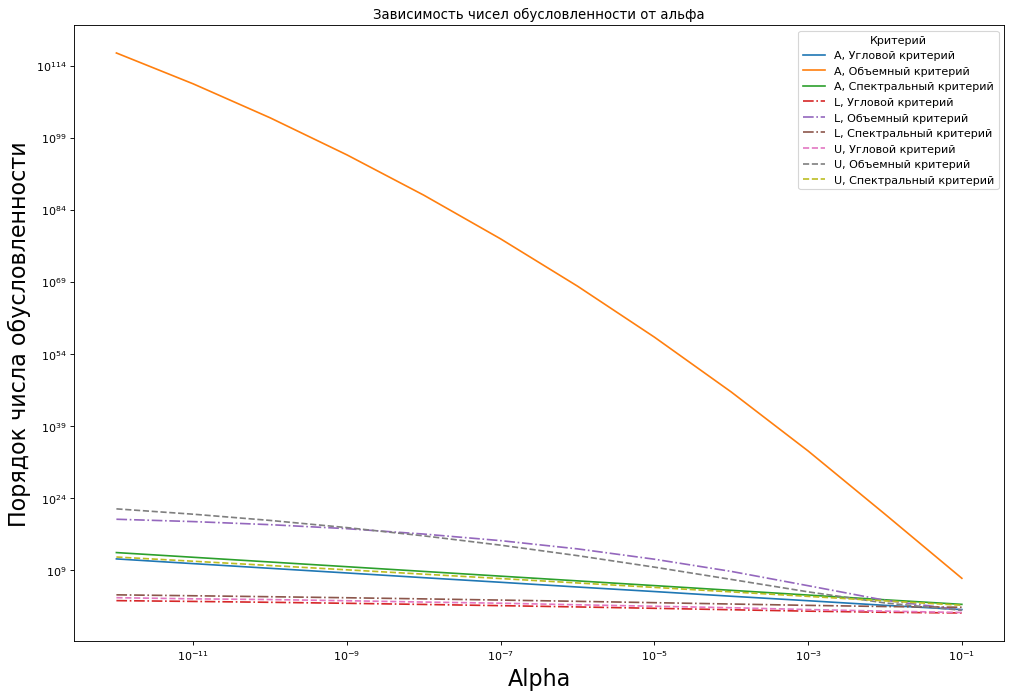

In [80]:
regularize(hilbert(17), build_plot=True)

Error: 0.0009853348906140207 with alpha 1e-12
Error: 7.622272412483714e-05 with alpha 1e-11
Error: 3.258651672016481e-05 with alpha 1e-10
Error: 9.766042660949157e-05 with alpha 1e-09
Error: 0.00031134834014924756 with alpha 1e-08
Error: 0.0009819675878289774 with alpha 1e-07
Error: 0.0030927504683268144 with alpha 1e-06
Error: 0.00977235668637093 with alpha 1e-05
Error: 0.03098216688120588 with alpha 0.0001
Error: 0.09856669794184902 with alpha 0.001
Error: 0.3153683937980602 with alpha 0.01
Error: 1.0061649334760578 with alpha 0.1
Best alpha: 1e-10


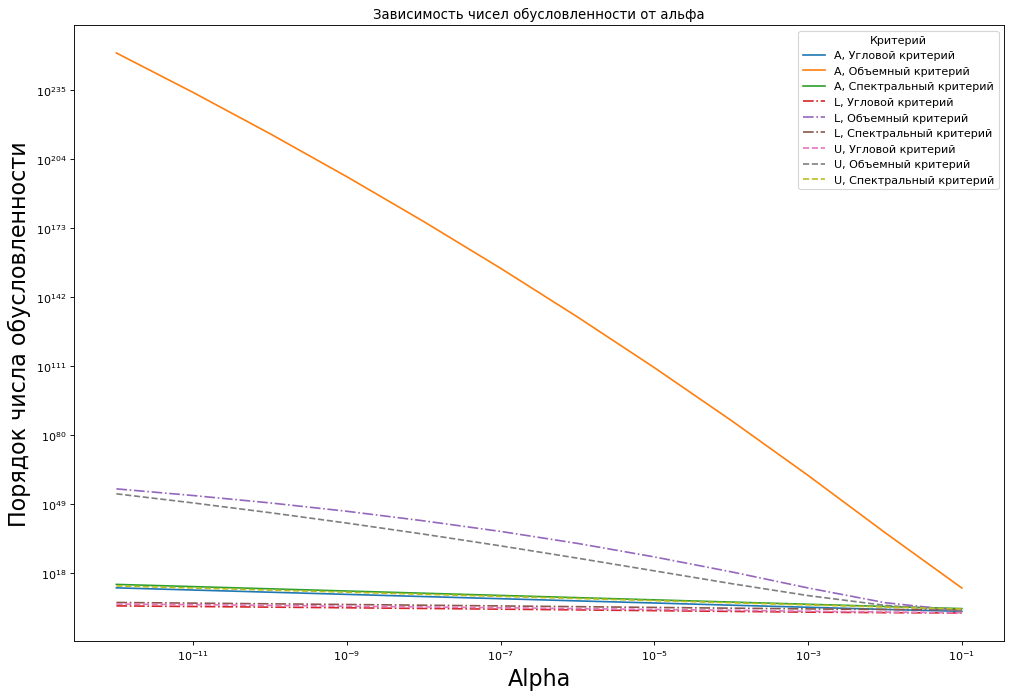

In [81]:
regularize(hilbert(30), build_plot=True)

# Лабораторная работа 3

## QR decomposition

In [82]:
def qr_decompose(A):
    N = A.shape[0]
    Q = np.identity(N)
    R = A.copy()
    for i in range(N):
        for j in range(i + 1, N):
            T = np.identity(N)

            sqrt = math.sqrt(R[i, i] ** 2 + R[j, i] ** 2)
            cos = R[i, i] / sqrt
            sin = -R[j, i] / sqrt

            T[i, i] = cos
            T[j, i] = sin
            T[j, j] = cos
            T[i, j] = -sin

            R = T @ R
            Q = T @ Q
    Q = np.linalg.inv(Q)

    for i in range(N):
        for j in range(i + 1, N):
            R[j, i] = 0

    return Q, R

In [83]:
def is_orthogonal(A):
    N = A.shape[0]
    I = np.identity(N)
    return np.allclose(A @ A.T, I) and np.allclose(A.T @ A, I)

class QRDecomposeTestCase(unittest.TestCase):
    @parameterized.expand([(i,) for i in range(3, 11)], name_func=test_name)
    def test_decompose(self, size):
        H = hilbert(size)
        Q, R = qr_decompose(H)
        self.assertTrue(is_orthogonal(Q)) # check if Q is orthogonal
        np.testing.assert_allclose(R, np.triu(R)) # check if R is upper triangular
        np.testing.assert_allclose(Q @ R, H) # check if Q * R == H

run_test(QRDecomposeTestCase)

test_decompose_10x10 (__main__.QRDecomposeTestCase) ... ok
test_decompose_3x3 (__main__.QRDecomposeTestCase) ... ok
test_decompose_4x4 (__main__.QRDecomposeTestCase) ... ok
test_decompose_5x5 (__main__.QRDecomposeTestCase) ... ok
test_decompose_6x6 (__main__.QRDecomposeTestCase) ... ok
test_decompose_7x7 (__main__.QRDecomposeTestCase) ... ok
test_decompose_8x8 (__main__.QRDecomposeTestCase) ... ok
test_decompose_9x9 (__main__.QRDecomposeTestCase) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.055s

OK


## Решение уравнения

In [84]:
def solve_qr(A, b):
    Q, R = qr_decompose(A)
    # solve Qy = b, Rx = y
    y = Q.T @ b
    x = solve_substitution(R, y, forward=False)
    return x

In [85]:
class SolveQRTestCase(unittest.TestCase):
    @parameterized.expand([(i,) for i in range(3, 8)], name_func=test_name)
    def test_solve_qr(self, size):
        H = hilbert(size)
        x = np.ones((size, 1))
        b = H @ x
        x_actual = solve_qr(H, b)
        np.testing.assert_allclose(x, x_actual)

run_test(SolveQRTestCase)

test_solve_qr_3x3 (__main__.SolveQRTestCase) ... ok
test_solve_qr_4x4 (__main__.SolveQRTestCase) ... ok
test_solve_qr_5x5 (__main__.SolveQRTestCase) ... ok
test_solve_qr_6x6 (__main__.SolveQRTestCase) ... ok
test_solve_qr_7x7 (__main__.SolveQRTestCase) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.016s

OK


## Сравнение с методом решения СЛАУ через LU разложение

In [114]:
def solve_qr_lu(A, b):
    Q, R = qr_decompose(A)
    x_qr = solve_qr(A, b)
    L, U = decompose(A)
    x_lu = solve_lu(A, b)
    return Q, R, x_qr, L, U, x_lu

def get_size_str(i):
    return str(i) + 'x' + str(i)

a_key = 'Угловой критерий'
v_key = 'Объемный критерий'
s_key = 'Спектральный критерий'
m_key = 'Матрица'
cond_data = {m_key: [], a_key: [], v_key: [], s_key: []}

lu_str = 'Погрешность решения через LU'
qr_str = 'Погрешность решения через QR'
error_data = {m_key: [], lu_str: [], qr_str: []}

def append_to_cond_data(m, m_str):
    size = m.shape[0]
    cond_data[m_key].append(get_size_str(size) + ', ' + m_str)
    cond_data[a_key].append(cond_a(m))
    cond_data[v_key].append(cond_v(m))
    cond_data[s_key].append(cond_s(m))

def append_to_error_data(m_str, x_lu, x_qr, x_actual):
    size = x_actual.shape[0]
    error_data[m_key].append(get_size_str(size) + ', ' + m_str)
    error_data[lu_str].append(error(x_lu, x_actual))
    error_data[qr_str].append(error(x_qr, x_actual))

def append_line():
    cond_data[m_key].append('')
    cond_data[a_key].append('')
    cond_data[v_key].append('')
    cond_data[s_key].append('')

def compare_hilbert(size):
    h = hilbert(size)
    x = np.ones((size, 1))
    b = h @ x
    Q, R, x_qr, L, U, x_lu = solve_qr_lu(h, b)
    append_to_cond_data(h, 'Hilbert')
    append_to_cond_data(Q, 'Q')
    append_to_cond_data(R, 'R')
    append_to_cond_data(L, 'L')
    append_to_cond_data(U, 'U')
    append_line()

    append_to_error_data('Hilbert', x_lu, x_qr, x)

for i in range(3, 11):
    compare_hilbert(i)

compare_hilbert(17)
compare_hilbert(20)

def print_table(data):
    print(tabulate(data, headers='keys', tablefmt='psql', numalign='left'))

### Сравнение чисел обусловленности

In [115]:
print_table(cond_data)

+----------------+------------------------+------------------------+-------------------------+
| Матрица        | Угловой критерий       | Объемный критерий      | Спектральный критерий   |
|----------------+------------------------+------------------------+-------------------------|
| 3x3, Hilbert   | 172.88724649319917     | 758.0469972237893      | 526.1588210797212       |
| 3x3, Q         | 1.0                    | 0.9999999999999998     | 3.0                     |
| 3x3, R         | 1.6437035980299068     | 1.7349636804440922     | 526.1588210797179       |
| 3x3, L         | 1.5811388300841902     | 1.6244657241348277     | 4.319243475139006       |
| 3x3, U         | 1.5811388300841902     | 1.6499158227686104     | 300.97908293467543      |
|                |                        |                        |                         |
| 4x4, Hilbert   | 4020.9134534334476     | 937085.8716080086      | 15613.79355964483       |
| 4x4, Q         | 1.0                    | 1.0   

### Сравнение погрешностей

In [116]:
print_table(error_data)

+----------------+--------------------------------+--------------------------------+
| Матрица        | Погрешность решения через LU   | Погрешность решения через QR   |
|----------------+--------------------------------+--------------------------------|
| 3x3, Hilbert   | 2.83018e-14                    | 1.68007e-15                    |
| 4x4, Hilbert   | 6.92978e-15                    | 3.09273e-13                    |
| 5x5, Hilbert   | 2.9976e-11                     | 9.48257e-12                    |
| 6x6, Hilbert   | 4.94351e-10                    | 1.07938e-09                    |
| 7x7, Hilbert   | 1.14211e-08                    | 3.48234e-08                    |
| 8x8, Hilbert   | 8.62783e-07                    | 1.0685e-07                     |
| 9x9, Hilbert   | 7.0305e-06                     | 2.30685e-05                    |
| 10x10, Hilbert | 0.000231677                    | 0.00193166                     |
| 17x17, Hilbert | 27.1034                        | 12.2834      